In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import thermal_analysis as ta
import image_analysis as ia

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.max_open_warning'] = False

___
___

## Import video with samples

In [18]:
# Inputting the video as a stack of arrays
frames_48 = ia.input_file('../../research/Data/20210222_N-methyl_NN-dymethil_Urea_150_Mon_Feb_22_18-42-06_2021.HDF5')

# Cropping all the frames in the video

crop_frame_48 = []
for frame in frames_48:
    crop_frame_48.append(frame[12:108,10:145])
crop_frame_48 = ia.flip_frame(crop_frame_48)

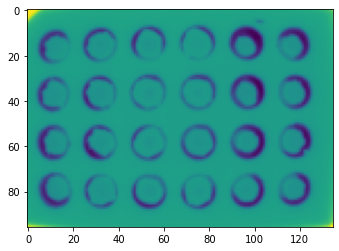

In [19]:
plt.imshow(crop_frame_48[-1])

### Find centroid using manual selection

In [20]:
% matplotlib qt

In [21]:
points = ia.manual_centroid(crop_frame_48[-1])

Remember to run the following command:  % matplotlib qt 
This way you are enabling the pop-up option for images

Select the centroid of each well. Right click once done. Middle mouse button removes most recent point.

Press keyboard button to save points and exit.

Now run the following command:  % matplotlib inline 
to reset the image visualization as inline in JN


In [22]:
% matplotlib inline

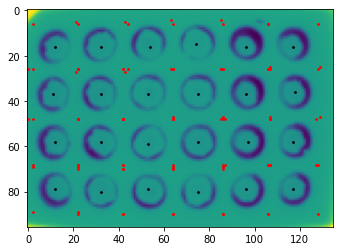

In [24]:
plate_loc_48 = ia.plate_location(points, 6,4)
plt.imshow(crop_frame_48[-1])
plt.scatter(points['Column'],points['Row'], c='k', s=3)
plt.scatter(plate_loc_48['Plate_col'],plate_loc_48['Plate_row'], c='r', s=3)

In [25]:
sample_temp_48, plate_temp_48 = ta.pixel_intensity(points,plate_loc_48, crop_frame_48, r=2)

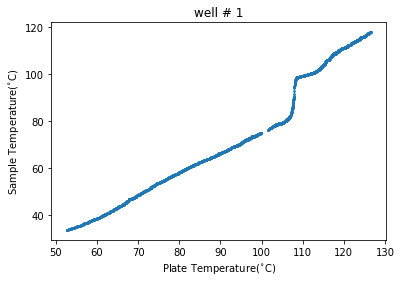

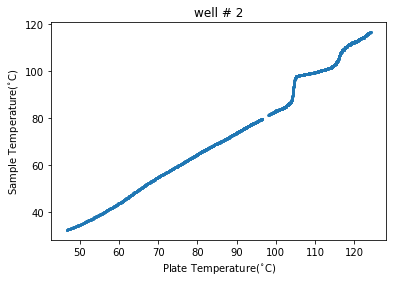

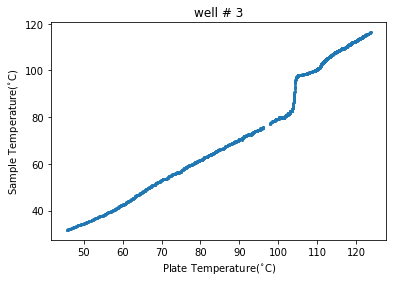

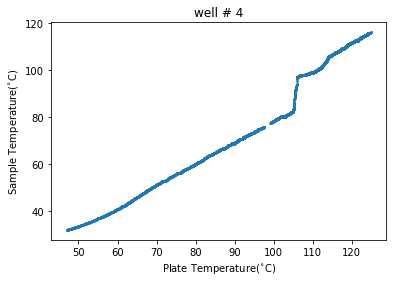

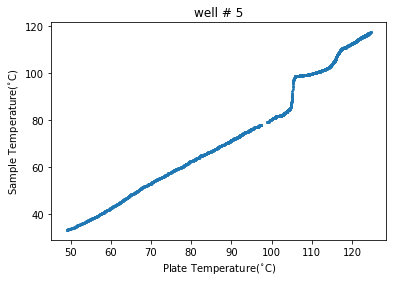

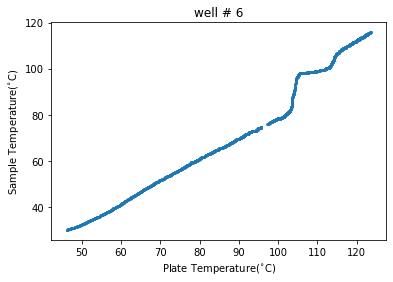

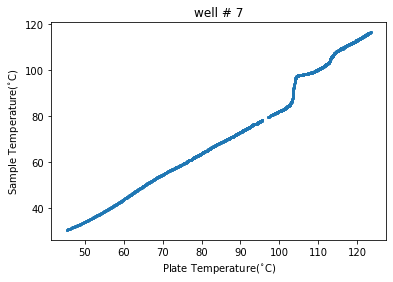

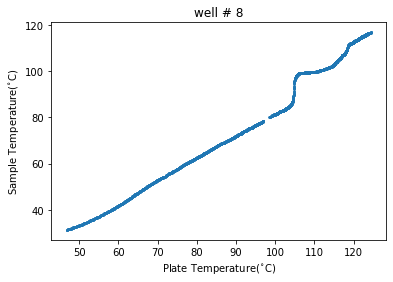

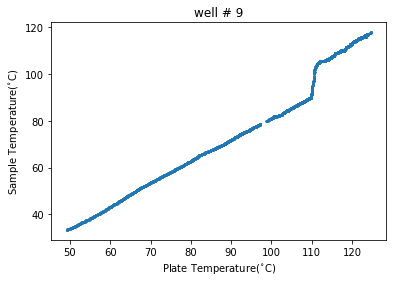

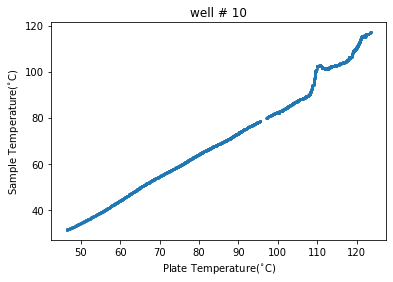

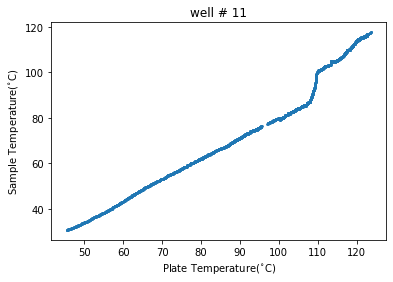

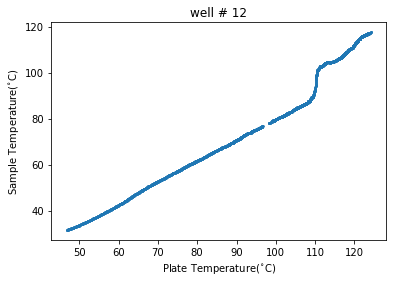

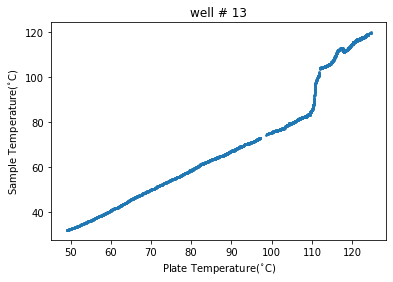

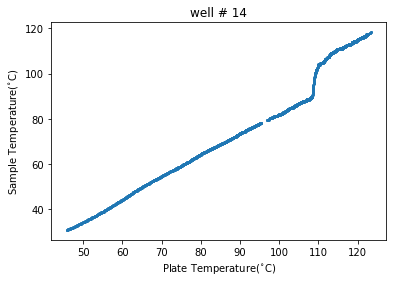

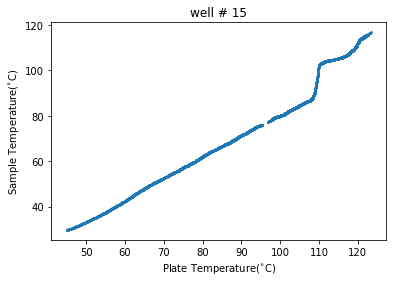

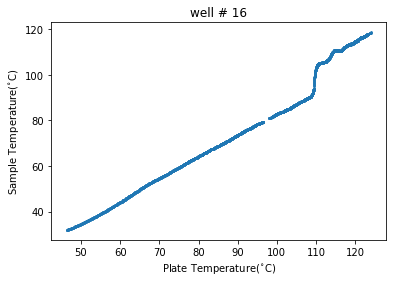

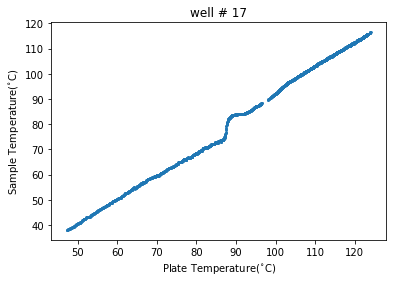

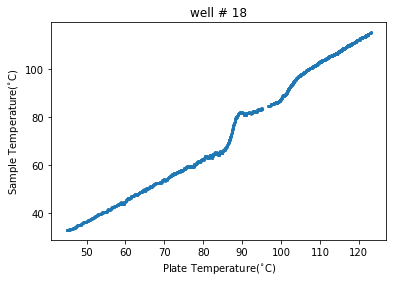

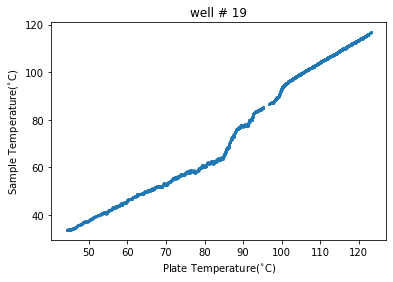

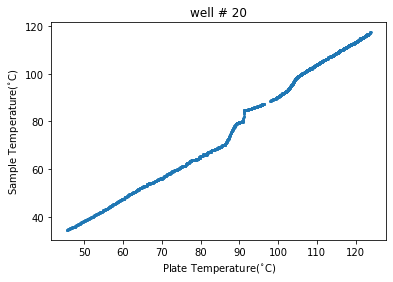

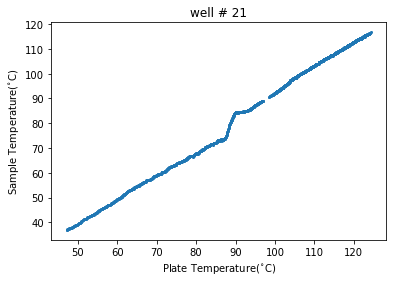

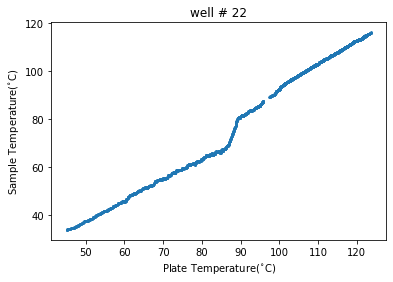

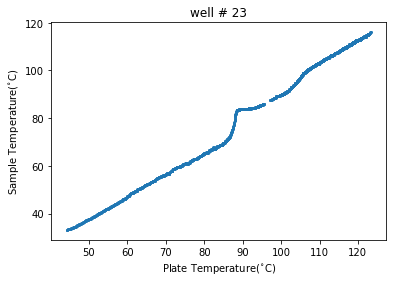

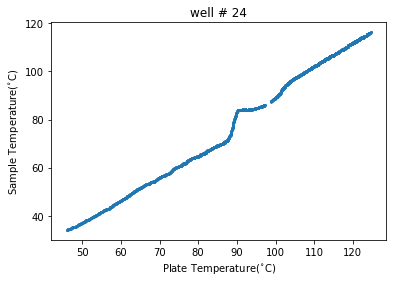

In [28]:
for i in range(len(sample_temp_48)):
    plt.scatter(plate_temp_48[i], sample_temp_48[i], s=3)
    plt.title('well # {}'.format(i+1))
    plt.xlabel('Plate Temperature($^{\circ}$C)')
    plt.ylabel('Sample Temperature($^{\circ}$C)')
    plt.show()

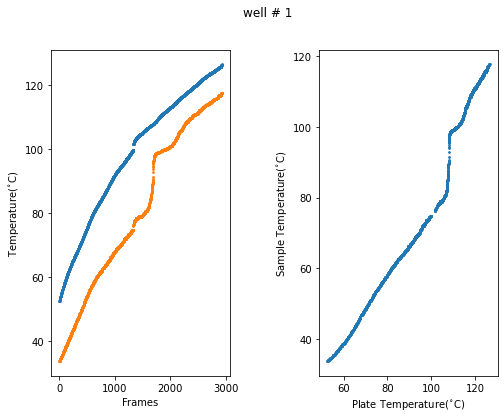

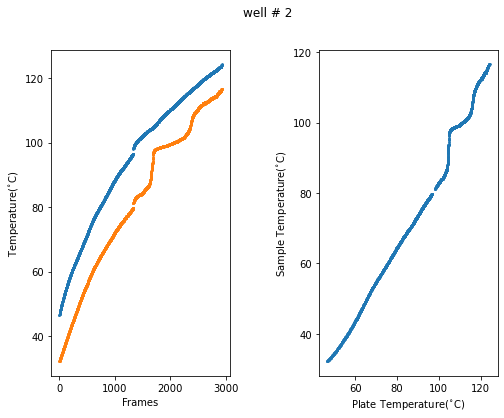

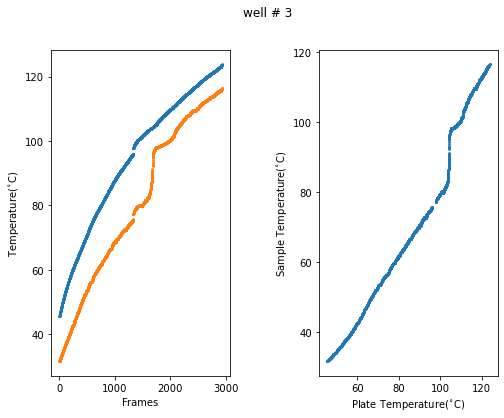

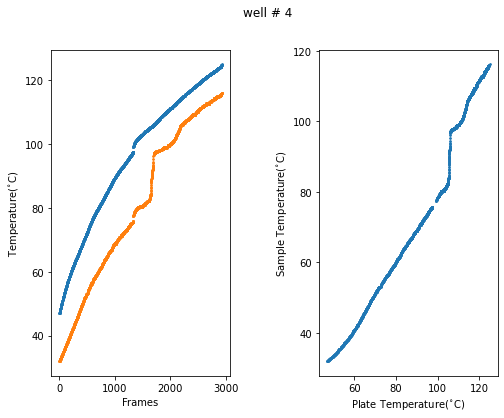

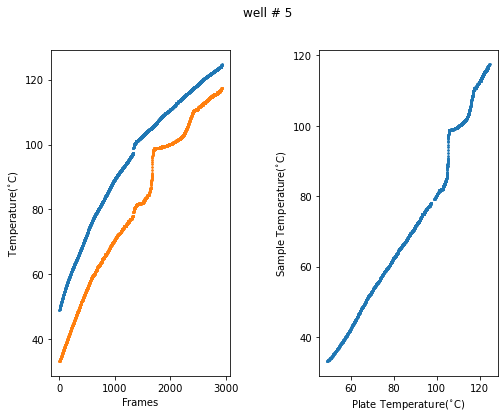

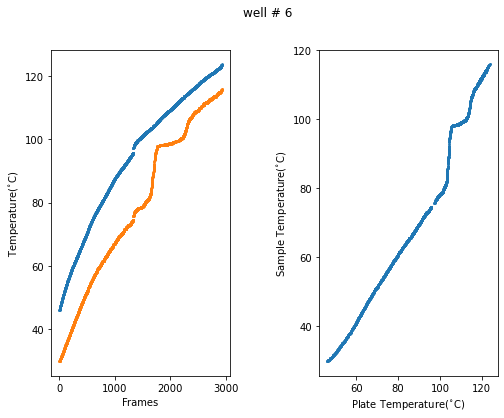

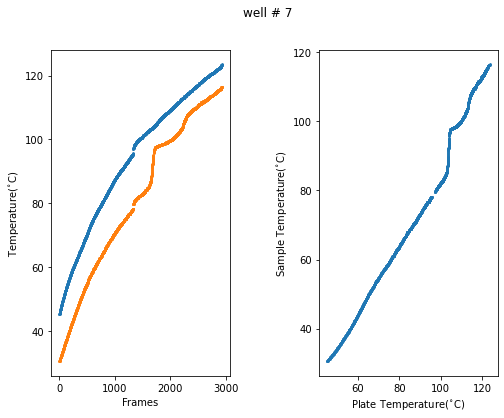

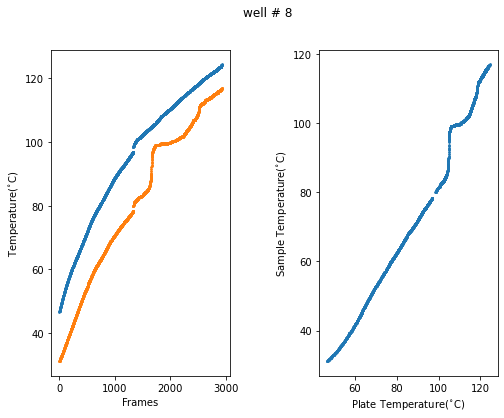

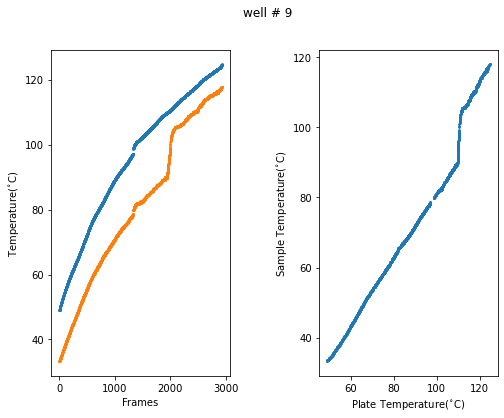

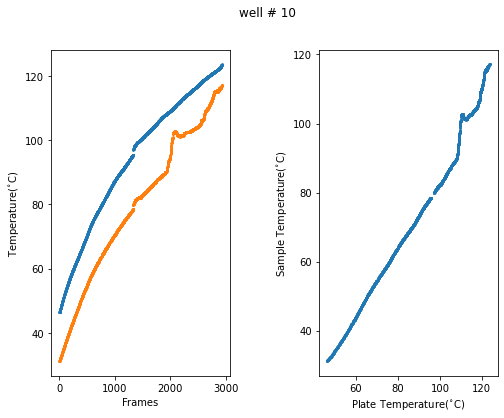

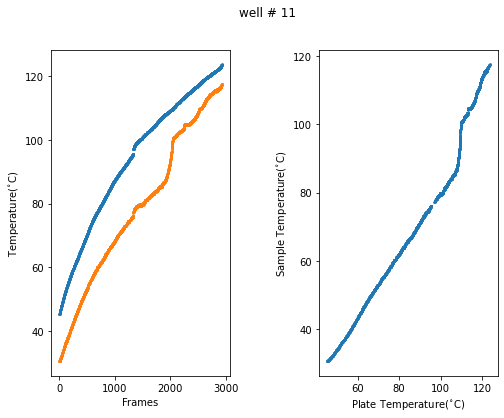

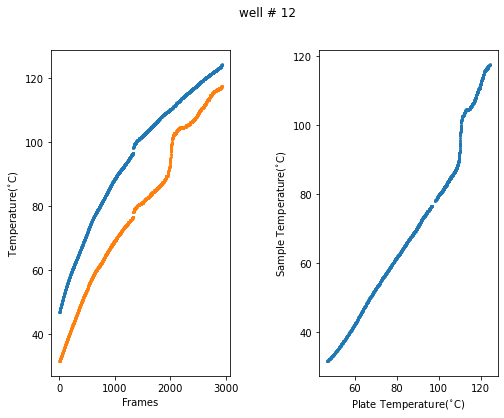

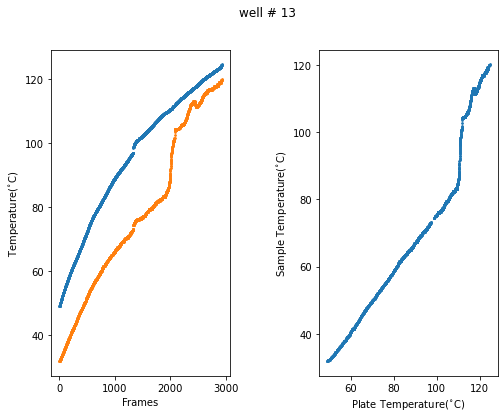

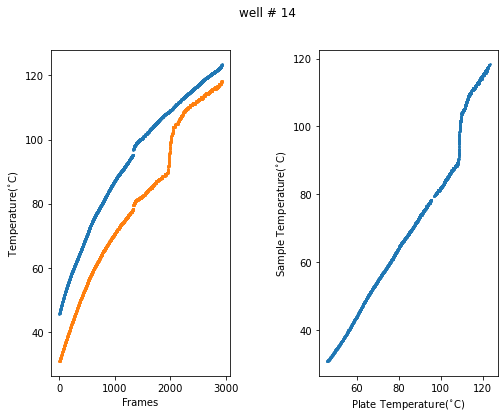

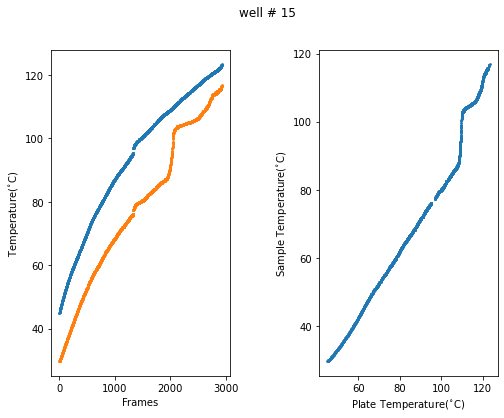

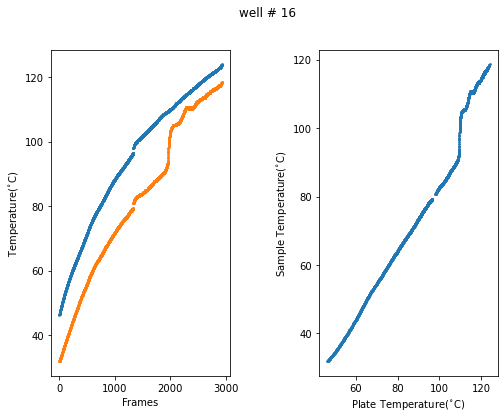

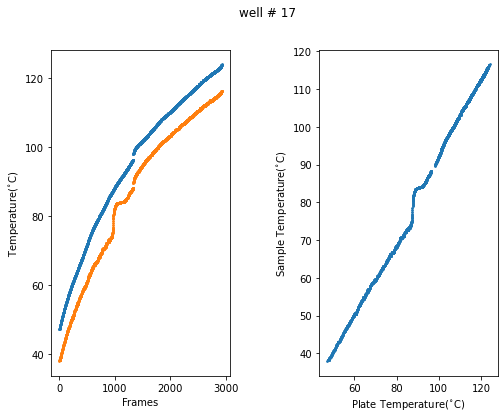

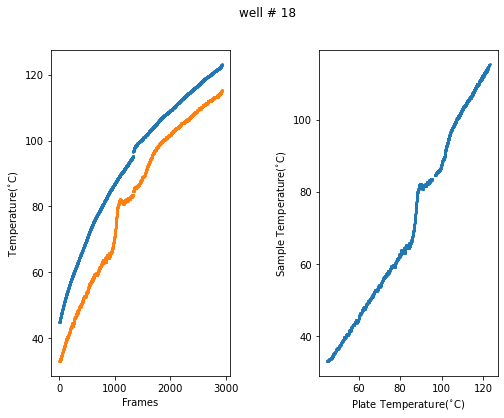

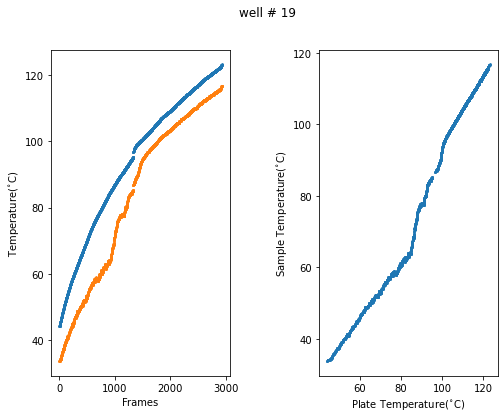

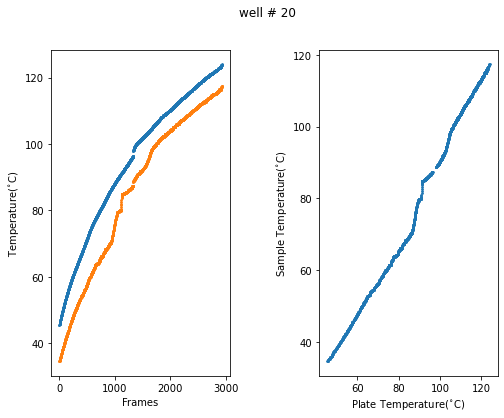

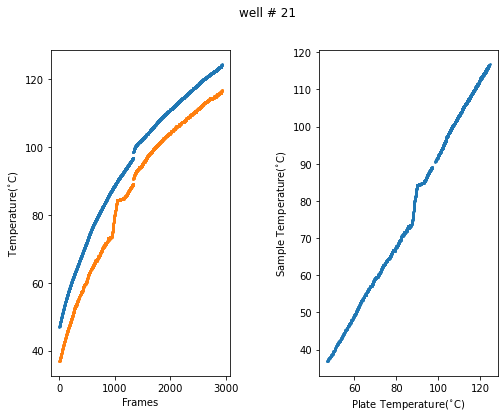

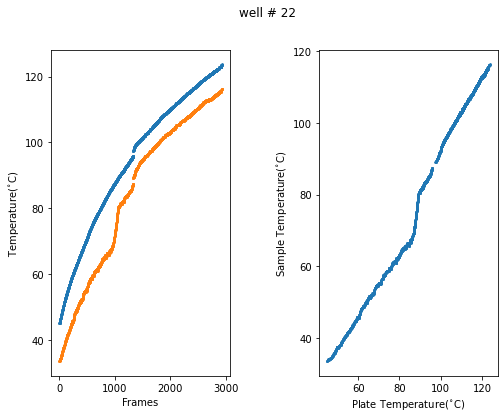

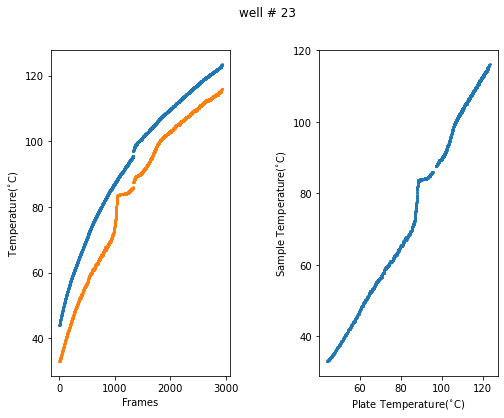

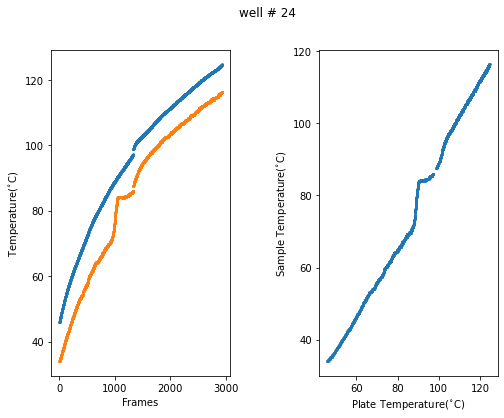

In [36]:
frames= np.linspace(1,len(sample_temp_48[0]), len(sample_temp_48[0]))
for i in range(len(sample_temp_48)):
    fig,ax = plt.subplots(1,2, figsize=(8,6))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle('well # {}'.format(i+1))
    ax[0].scatter(frames,plate_temp_48[i], label='Plate_temp',s=3)
    ax[0].scatter(frames,sample_temp_48[i], label='Sample_temp',s=3)
    ax[1].scatter(plate_temp_48[i], sample_temp_48[i], s=3)
    ax[1].set_xlabel('Plate Temperature($^{\circ}$C)')
    ax[1].set_ylabel('Sample Temperature($^{\circ}$C)')
    ax[0].set_xlabel('Frames')
    ax[0].set_ylabel('Temperature($^{\circ}$C)')
    plt.show()

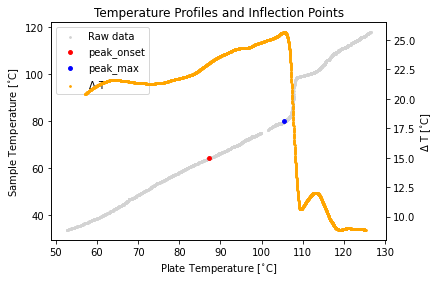

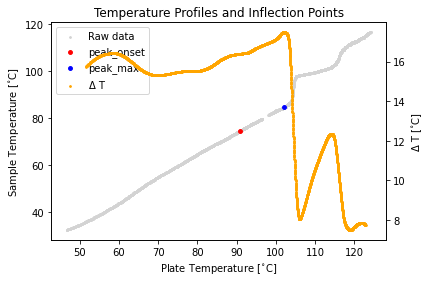

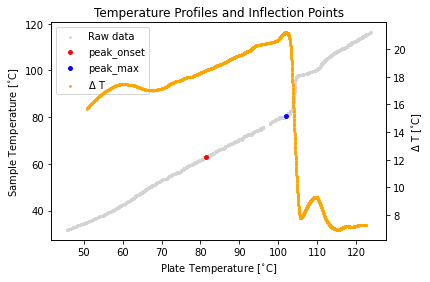

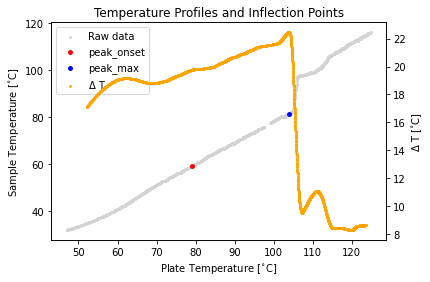

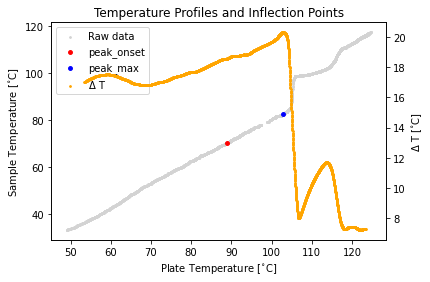

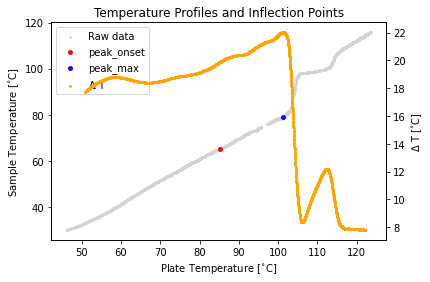

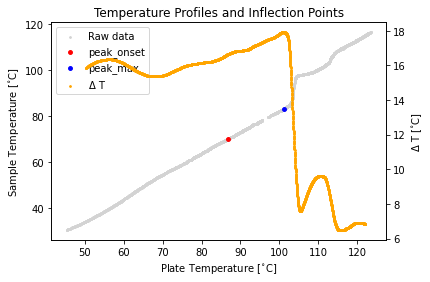

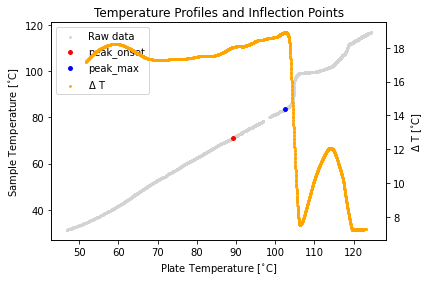

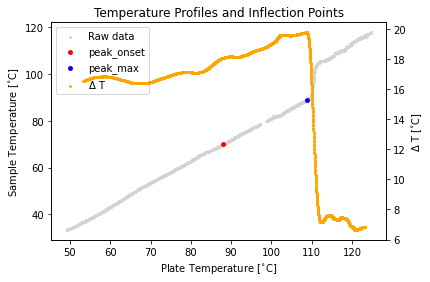

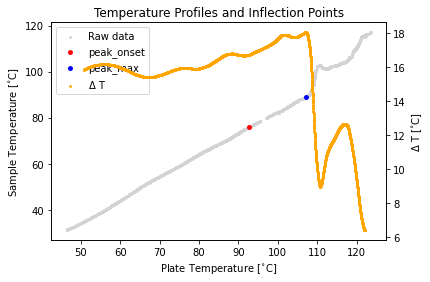

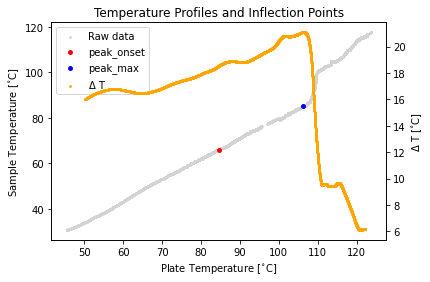

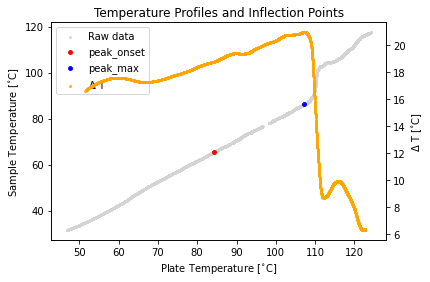

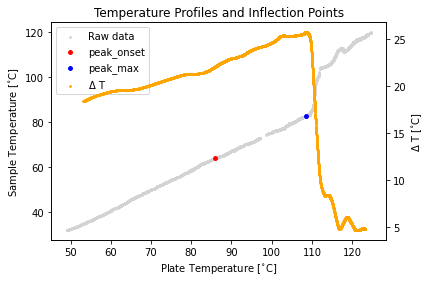

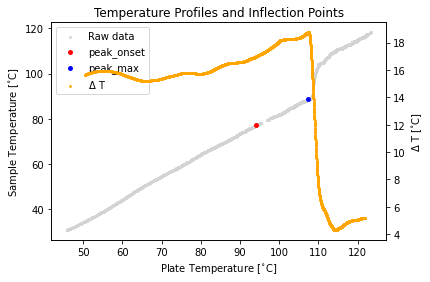

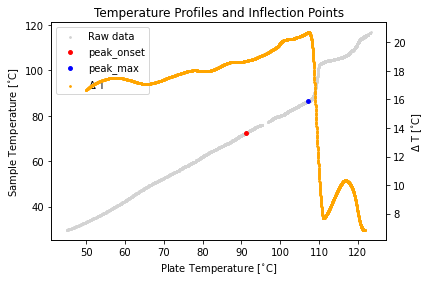

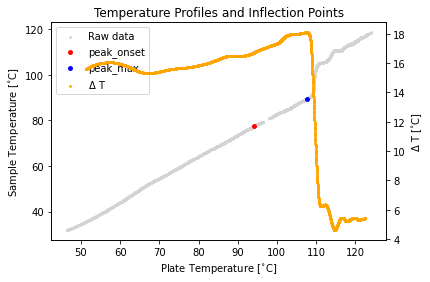

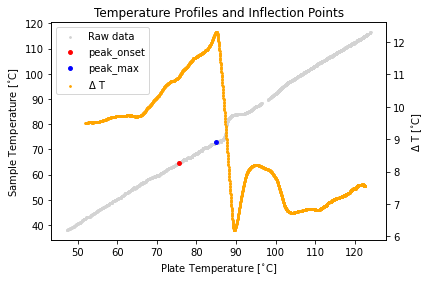

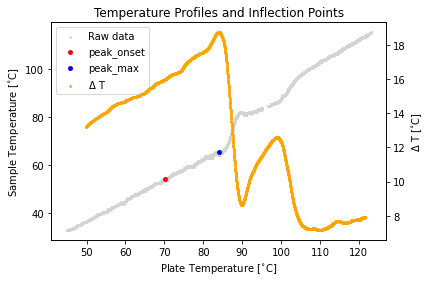

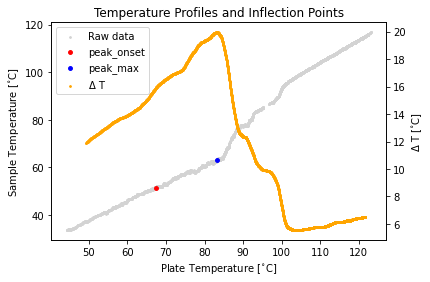

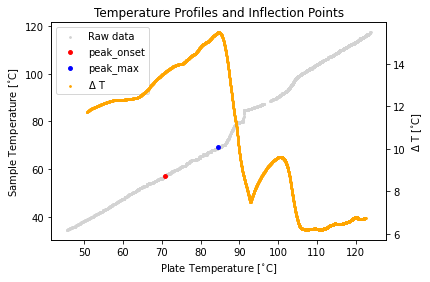

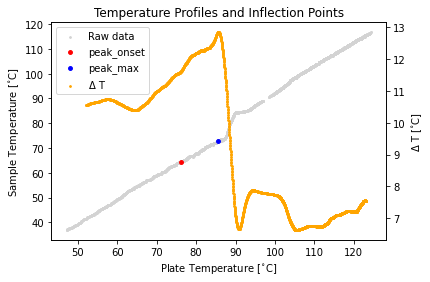

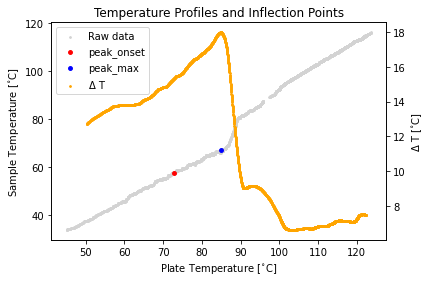

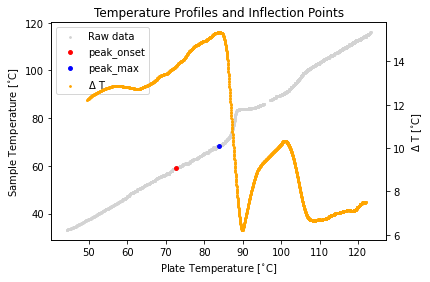

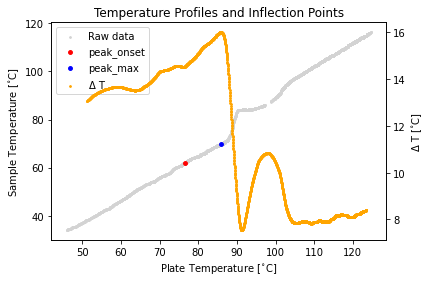

In [26]:
temp_df = ta.phase_transition_temperature(plate_temp_48, sample_temp_48,plot=True)

In [37]:
temp_df

,Sample_temp_onset,Sample_temp_peak,Plate_temp_onset,Plate_temp_peak
0,64.17,79.87,87.19,105.53
1,74.48,84.71,90.88,102.19
2,62.85,80.69,81.30,101.90
3,59.36,81.38,79.12,103.84
4,70.32,82.50,88.88,102.81
5,65.25,79.21,85.10,101.23
6,70.08,83.18,86.72,101.09
7,71.19,83.62,89.23,102.55
8,69.96,88.95,88.03,108.72
9,75.98,89.12,92.70,107.15


___
___

In [39]:
def baseline_method(plate_temp, sample_temp, option=None):
    test_df = pd.DataFrame({'Frames':np.linspace(1,len( plate_temp), len( plate_temp)),
                        'Plate_temp': plate_temp, 'Sample_temp':  sample_temp})
    n= int(0.05*len(test_df['Plate_temp']))
    test_df['Plate_avg']=test_df.iloc[:,1].rolling(window=n).mean()
    test_df['Sample_avg']=test_df.iloc[:,2].rolling(window=n).mean()
    removed_baseline = test_df['Plate_avg']-test_df['Sample_avg']
    if option:
        fig, ax = plt.subplots() 
        ax.semilogx(test_df['Frames'],test_df['Plate_avg'], c='red', label='Plate Temp')
        ax.semilogx(test_df['Frames'],test_df['Sample_avg'], c='blue', label='Sample Temp')
        ax1=ax.twinx()
        ax1.semilogx(test_df['Frames'], removed_baseline, c='orange', label='Removed Baseline')
        ax.set_xlabel('Frames')
        ax.set_ylabel(' Temperature ')
        ax.legend()
    else:
        fig, ax = plt.subplots() 
        ax.scatter(test_df['Frames'],test_df['Plate_avg'], c='red', label='Plate Temp', s=3)
        ax.scatter(test_df['Frames'],test_df['Sample_avg'], c='blue', label='Sample Temp', s=3)
        ax1=ax.twinx()
        ax1.scatter(test_df['Frames'], removed_baseline, c='orange', label='Removed Baseline', s=3)
        ax.set_xlabel('Frames')
        ax.set_ylabel(' Temperature ')
        ax.legend()
    return test_df

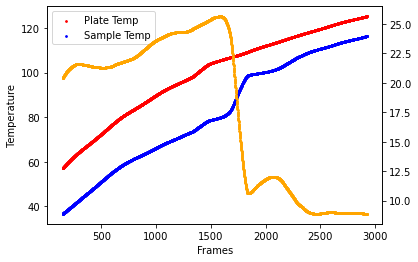

In [40]:
dataframe= baseline_method(plate_temp_48[0], sample_temp_48[0])

In [41]:
baseline = dataframe['Plate_avg']-dataframe['Sample_avg']

In [43]:
from scipy.signal import find_peaks, peak_widths

In [51]:
peaks, properties = find_peaks(baseline, height=5)
peak_heights = properties['peak_heights']
peak_max = [i for i in range(len(peak_heights))
            if peak_heights[i] == max(peak_heights)]
peaks_w = peak_widths(baseline, peaks[peak_max])

peak_left_onset = int(round(peaks_w[2][0]))

In [47]:
peak_heights

array([21.60734209, 21.61214231, 21.61229072, 21.61187785, 21.61165906,
       21.60774924, 21.36011225, 21.35843417, 21.34047374, 21.33984589,
       21.29076865, 21.29118531, 21.29116248, 21.29202816, 21.29346842,
       21.29794901, 21.30252664, 21.30608067, 24.28315068, 24.32019026,
       24.33133181, 24.33247336, 24.3336796 , 24.32226027, 25.65663432,
       12.05067542,  8.90009513,  8.89987443,  8.90011796,  8.87609589,
        8.93817352,  8.93949011,  9.02626332,  9.01603501,  9.01613014,
        8.96268645,  8.96229642,  8.96358638,  8.96406773,  8.9636777 ,
        8.96134513,  8.9588965 ,  8.95994102,  8.96018836,  8.96978501,
        8.97109779,  8.9711796 ,  8.9630879 ,  8.96297374,  8.94283295,
        8.93753995,  8.96555936,  8.96378044,  8.96374429,  8.9583828 ,
        8.89840944,  8.89907344])

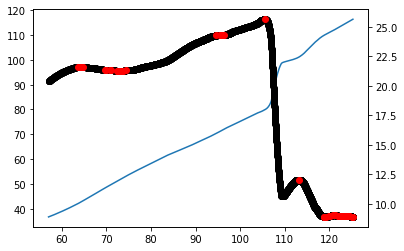

In [52]:
fig, ax= plt.subplots()
ax.plot(dataframe['Plate_avg'], dataframe['Sample_avg'])
ax1= ax.twinx()
ax1.scatter(dataframe['Plate_avg'], baseline, c= 'k', s= 3)
ax1.scatter(dataframe['Plate_avg'].iloc[peaks], baseline[peaks], c='r', s=2)